# Pendulum

Dans ce notebook, on s'intéressera à la résolution du problème du [Pendulum](https://www.gymlibrary.dev/environments/classic_control/pendulum/) disponible sur la plateforme gymnasium d'OpenAI :

<img src = "https://www.gymlibrary.dev/_images/pendulum.gif" width="520" height="520" style="margin:auto"/>


L'objectif est d'apprendre au pendule comment atteindre  la position verticale et se stabiliser. 

Initialement, nous nous sommes intéressés à l'algorithme REINFORCE. Pour cela, nous avons utilisé un modèle paramétrique présenté dans le livre 'REINFORCEMENT LEARNING' de S. Sutton et G. Barton. Dans la section 13.7, le livre présente un modèle d'apprentissage de densités gaussiennes avec des modèles d'espérance et de variance pour la politique. Nous n'avons pas réussi à obtenir un algorithme d'apprentissage efficace.

Pour résoudre ce problème, nous avons choisi d'utiliser d'autres algorithmes de renforcement par montée de gradient sur une politique paramétrique, les modèles Acteur-Critique. En particulier, l'algorithme de Deep Deterministic Gradient Policy (DDPG). 

## Algorithme DDPG

L'algorithme DDPG utilise un modèle Acteur-Critique qui permet d'apprendre sur des espaces d'action et d'état continues. La politique paramétrique est un réseau de neurone, l'acteur. Pour entrainer cette politique, nous utilisons un modèle paramétrique de la Q-value fonction, le critique. Ainsi, à chaque proposition d'action de l'acteur, le critique évalue la Q-value fonction pour l'état et l'action proposée pour déterminer si c'est un bon choix ou non. Réciproquement, le critique exploite la politique pour s'améliorer avec l'équation de Bellman, où l'action est prévue par l'acteur.

Ainsi, l'acteur et le critique s'améliorent réciproquement jusqu'à atteindre la politique et la Q-value fonction optimales.

DDPG utilise aussi 2 techniques importantes :

- L'utilisation d'un buffer stockant les anciennes étapes : On garde en mémoire tous les tuples (state, action, reward, next_state). Ensuite, on réalisera les optimisations de chacun des réseaux de neurones sur un échantillon de taille **batch_size** constante tirés uniformément dans ce buffer. On notera que le buffer n'est pas vidé entre les épisodes.
- L'utilisation d'un doublon pour chaque réseau de neurones : Si on utilise le même réseau de neurone pour  qu'il se mette à jour lui-même, il devient instable. Pour éviter cela, on utilise une copie de chaque réseau (acteur et critique) nommé target pour mettre à jour les modèles. Ensuite, les paramètres des réseaux targets sont mis à jour à chaque étape de l'algorithme par la formule $$ \theta_{target} = \tau\theta_{target} + (1 - \tau)\theta_{model} $$ où $\tau$ est proche de 1.

L'algorithme est présenté précisément dans l'article "Continuous control with deep reinforcement learning" (https://arxiv.org/abs/1509.02971). 

Voici un extrait du pseudo-code de l'algorithme proposé dans l'article : 

<img src="https://i.imgur.com/mS6iGyJ.jpg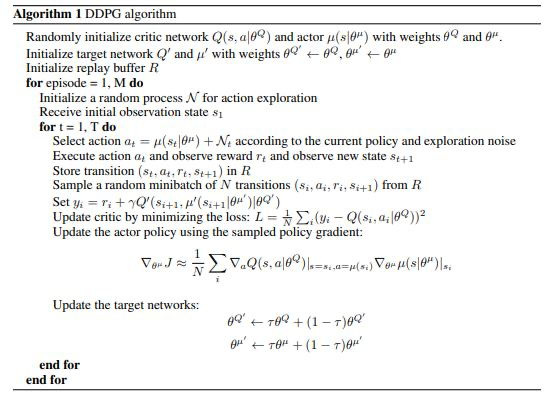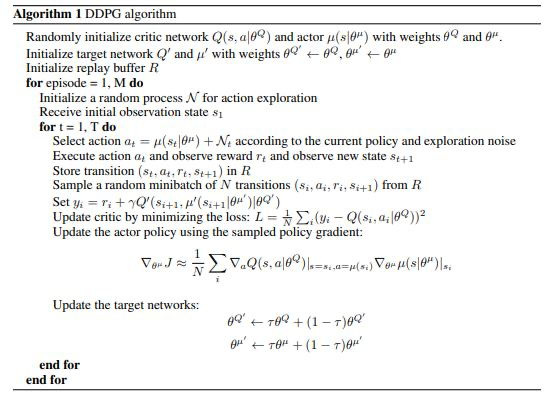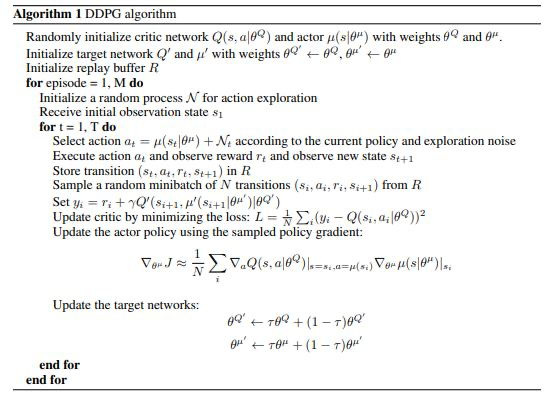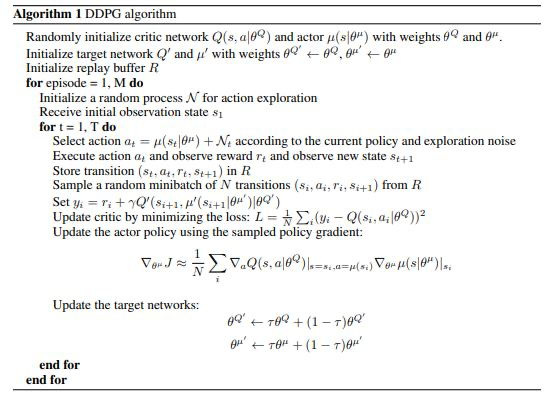" style="margin:auto"/>

### Mise en place de l'environnement

In [57]:
import gymnasium as gym
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [53]:
problem = "Pendulum-v1"
env = gym.make(problem)
#env = gym.make(problem, render_mode = "human")

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]


On observe que le problème est décrit à chaque instant par un état contenant 3 variables et une action compris entre [-2, 2]

In [3]:
print(f"Taille d'un état : \t {num_states}")
print(f"Taille d'une action : \t {num_actions}")
print(f"Bornes de l'action : \t [{lower_bound}, {upper_bound}]")

Taille d'un état : 	 3
Taille d'une action : 	 1
Bornes de l'action : 	 [-2.0, 2.0]


## Bruit

Pour piloter l'exploration de notre agent et aussi améliorer sa stabilité, nous utiliserons du bruit pour perturber l'action de la politique à chaque fois. On peut utiliser plusieurs bruits. Ici nous en présenterons 3.

- Le bruit d'Ornstein-Uhlenbeck, solution initiale proposée avec l'algorithme DDPG dans le ARTICLE (Continuous control with deep reinforcement learning, 2015, https://arxiv.org/abs/1509.02971). En effet, le processus d'Ornstein-Uhlenbeck a pour propriété d'être gaussien à chaque instant et à générer des variables aléatoires corrélés. C'est aussi un processus de Markov. Initialement, l'algorithme DDPG ajoute une réalisation de ce processus à chaque action que le réseau de neurone action réalise.

In [4]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

- Le bruit gaussien, simplement généré par des variables aléatoires gaussiennes i.i.d, est une autre façon de réaliser du bruit. On ajoute une réalisation d'une gaussienne à l'action suggéré par la politique de l'acteur.

- Enfin, une dernière approche plus récente serait de perturber l'action non pas après qu'elle ait été calculé mais directement dans le réseau de neurones. En effet, on peut perturber légèrement les poids du réseau de neurone de l'acteur avant de lui soumettre l'état **state**. L'action résultante serait ainsi bruitée différemment.

In [5]:
from enum import Enum

class Bruit(Enum):
    Gaussien = 1
    OU = 2

### Buffer

Pour implémenter l'algorithme DDPG, il faut utiliser un buffer. Le buffer est un élément important et utile dans l'algorithme DDPG car il permet d'éviter les problèmes de corrélation entre les transitions, améliore la stabilité de l'apprentissage et permet de minimiser les effets de l'instabilité des mises à jour.

In [6]:
class ReplayBuffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.buffer_counter += 1

    # Return a batch from the buffer
    def getBatch(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices], dtype = tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        return state_batch, action_batch, reward_batch, next_state_batch

### Bruit

Pour piloter l'exploration de notre agent et aussi améliorer sa stabilité, nous utiliserons du bruit pour perturber l'action de la politique à chaque fois. On peut utiliser plusieurs bruits. Ici nous en présenterons 3.

- Le bruit d'Ornstein-Uhlenbeck, solution initiale proposée avec l'algorithme DDPG dans le ARTICLE (Continuous control with deep reinforcement learning, 2015, https://arxiv.org/abs/1509.02971). En effet, le processus d'Ornstein-Uhlenbeck a pour propriété d'être gaussien à chaque instant et à générer des variables aléatoires corrélés. C'est aussi un processus de Markov. Initialement, l'algorithme DDPG ajoute une réalisation de ce processus à chaque action que le réseau de neurone action réalise.

In [7]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

- Le bruit gaussien, simplement généré par des variables aléatoires gaussiennes i.i.d, est une autre façon de réaliser du bruit. On ajoute une réalisation d'une gaussienne à l'action suggéré par la politique de l'acteur.

- Enfin, une dernière approche plus récente serait de perturber l'action non pas après qu'elle ait été calculé mais directement dans le réseau de neurones. En effet, on peut perturber légèrement les poids du réseau de neurone de l'acteur avant de lui soumettre l'état state. L'action résultante serait ainsi bruitée différemment.

In [8]:
from enum import Enum

class Bruit(Enum):
    Gaussien = 1
    OU = 2

### Acteur et Critique

On définit une classe Actor pour représenter l'acteur : 

In [9]:
class Actor : 
    def __init__(self, lr, tau = 0.005, bruit = Bruit.Gaussien, std_dev = 0.25):
        self.lr = lr
        self.tau = tau
        self.model = self.make_actor()
        self.target = self.make_actor()
        self.bruit = bruit
        self.std_dev = std_dev
        self.optimizer = tf.keras.optimizers.Adam(lr)
        # Making the weights equal initially
        self.target.set_weights(self.model.get_weights())
        
        if bruit == Bruit.OU:
            self.noise_generator = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
        elif bruit == Bruit.Gaussien: 
            self.noise_generator = lambda : np.array([np.random.randn()*self.std_dev])
        else: 
            raise Exception("Bruit non attendu")

    def make_actor(self):
        # Initialize weights between -3e-3 and 3-e3
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

        inputs = layers.Input(shape=(num_states,))
        out = layers.Dense(256, activation="relu")(inputs)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

        # Our upper bound is 2.0 for Pendulum.
        outputs = outputs * upper_bound
        model = tf.keras.Model(inputs, outputs)
        return model
    
    def policy_parameter_space(self, state):
        return True
    
    def policy(self, state):
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        sampled_actions = tf.squeeze(self.model(tf_state))
        sampled_actions = sampled_actions.numpy() + self.noise_generator()

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
        return [np.squeeze(legal_action)]
    
    def update(self, batch, critic):
        state_batch, action_batch, reward_batch, next_state_batch = batch        
        with tf.GradientTape() as tape:
            actions = self.model(state_batch, training=True)
            critic_value = critic.model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(actor_grad, self.model.trainable_variables)
        )
        
    # This update target parameters slowly
    # Based on rate `tau`, which is much less than one.
    @tf.function
    def update_target(self):
        for (a, b) in zip(self.target.variables, self.model.variables):
            a.assign(b * self.tau + a * (1 - self.tau))

On définit une classe Critic pour représenter l'acteur : 

In [10]:
class Critic:
    def __init__(self, lr, tau = 0.005):
        self.lr = lr
        self.tau = tau
        self.model = self.make_critic()
        self.target = self.make_critic()
        self.optimizer = tf.keras.optimizers.Adam(lr)

        # Making the weights equal initially
        self.target.set_weights(self.model.get_weights())


    def make_critic(self):
        # State as input
        state_input = layers.Input(shape=(num_states))
        state_out = layers.Dense(16, activation="relu")(state_input)
        state_out = layers.Dense(32, activation="relu")(state_out)

        # Action as input
        action_input = layers.Input(shape=(num_actions))
        action_out = layers.Dense(32, activation="relu")(action_input)

        # Both are passed through seperate layer before concatenating
        concat = layers.Concatenate()([state_out, action_out])

        out = layers.Dense(256, activation="relu")(concat)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1)(out)

        # Outputs single value for give state-action
        model = tf.keras.Model([state_input, action_input], outputs)

        return model
    
    def update(self, batch, actor):
        state_batch, action_batch, reward_batch, next_state_batch = batch
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = actor.target(next_state_batch, training=True)
            y = reward_batch + gamma * self.target(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(critic_grad, self.model.trainable_variables)
        )
    # This update target parameters slowly
    # Based on rate `tau`, which is much less than one.
    @tf.function
    def update_target(self):
        for (a, b) in zip(self.target.variables, self.model.variables):
            a.assign(b * self.tau + a * (1 - self.tau))

### Initialisation des paramètres

In [11]:
class DDPG:
    def __init__(self, gamma, actor_lr = 0.001, critic_lr = 0.002, tau = 0.005, total_episodes = 100, 
                 buffer_capacity = 10000, batch_size = 64, bruit = Bruit.Gaussien, std_dev = None):
        self.gamma = gamma
        self.actor = Actor(actor_lr, tau, bruit, std_dev)
        self.critic = Critic(critic_lr, tau)
        self.buffer = ReplayBuffer(buffer_capacity, batch_size)
        self.total_episodes = total_episodes
        self.episode_rewards = []
        self.avg_rewards = []
    
    def train(self, debug = True):
        for ep in range(total_episodes):
            prev_state, _ = env.reset()
            episodic_reward = 0
            step = 0
            while True:
                action = self.actor.policy(prev_state)

                state, reward, done, truncated, info = env.step(action)

                self.buffer.record((prev_state, action, reward, state))
                episodic_reward += reward

                batch = self.buffer.getBatch()
                self.critic.update(batch, self.actor)
                self.actor.update(batch, self.critic)
                
                self.critic.update_target()
                self.actor.update_target()

                # End this episode when `done` is True
                if done or truncated:
                    break

                prev_state = state
                step += 1

            self.episode_rewards.append(episodic_reward)

            # Mean of last 40 episodes
            avg_reward = np.mean(self.episode_rewards[-40:])
            if debug : 
                print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
            self.avg_rewards.append(avg_reward)
        print("Entrainement terminé")
    
    
    def run(self):
        for ep in range(total_episodes):
            prev_state, _ = env.reset()
            while True:
                action = actor.policy(prev_state, ou_noise)
                state, _, done, truncated, _ = env.step(action)
                if done or truncated:
                    break
                prev_state = state
    
    def plot(self):
        plt.plot(avg_reward_list)
        plt.xlabel("Episode")
        plt.ylabel("Avg. Epsiodic Reward")
        plt.show() 
        
    def save_data(self, filename = None):
        import pickle
        filename = filename if not None else f"Pendulum/results/DDPG_bs{self.buffer.batch_size}_alr{self.actor.lr}_clr{self.critic.lr}_br{self.actor.bruit}_dev{self.actor.std_dev}.pickle"
        if self.avg_rewards or self.episode_rewards:
            with open(filename, "wb") as fichier:
                pickle.dump({
                    "parameters": {
                        "gamma" : self.gamma,
                        "tau" : self.actor.tau,
                        "actor_lr" : self.actor.lr,
                        "critic_lr" : self.critic.lr,
                        "bruit" : self.actor.bruit,
                        "std_dev" : self.actor.std_dev,
                        "batch_size" : self.buffer.batch_size
                    },
                    "data": {
                        "episode_rewards" : self.episode_rewards
                    }
                }, fichier)
    def load_data(self, batch_size, actor_lr, critic_lr, bruit, std_dev):
        import pickle
        with open(f"Pendulum/results/DDPG_bs{batch_size}_alr{actor_lr}_clr{critic_lr}_br{bruit}_dev{std_dev}.pickle", "rb") as fichier:
            data = pickle.load(fichier)
            return data
        

In [ ]:
# Standard deviation for noises
std_dev = 0.25

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001
total_episodes = 100

# Discount factor for future rewards
gamma = 0.99

# Used to update target networks
tau = 0.005
batch_size = 64

#my_ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, bruit = Bruit.OU, std_dev = std_dev)
#my_ddpg.train()

## Interprétation des résultats

Nous avons lancé plusieurs simulations en faisant varier les paramètres sur différentes plages de valeurs. 

De manière générale, les paramètres utilisés étaient les suivants

In [23]:
# Standard deviation for noises
std_dev = 0.25

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

# Discount factor for future rewards
gamma = 0.99

# Used to update target networks
tau = 0.005

# Number of elements of the buffer on which networks train each time
batch_size = 64

Ensuite, nous avons fait varier chaque paramètre à la fois sur une plage pour 100 épisodes. Etant donné les temps de calcul, nous avons sauvegardé les simulations liés à chaque paramètre dans un fichier spécifiques, de manière à ne pas avoir à réentrainer les algorithmes. 

In [38]:
import pickle
plt.rcParams['figure.figsize'] = [15, 7] # Scale up charts 
def plot_data(parameter_name):
    with open(f"Pendulum/results/DDPG_range_{parameter_name}", "rb") as fichier:
        data = pickle.load(fichier)
    print(data)
    for simu in data:
        plt.plot(simu["data"]["episode_rewards"], label=f"{parameter_name} = {simu['parameters'][parameter_name]}")
    plt.legend()
    plt.show()

### Gamma

Faisons varier les valeurs de gamma :

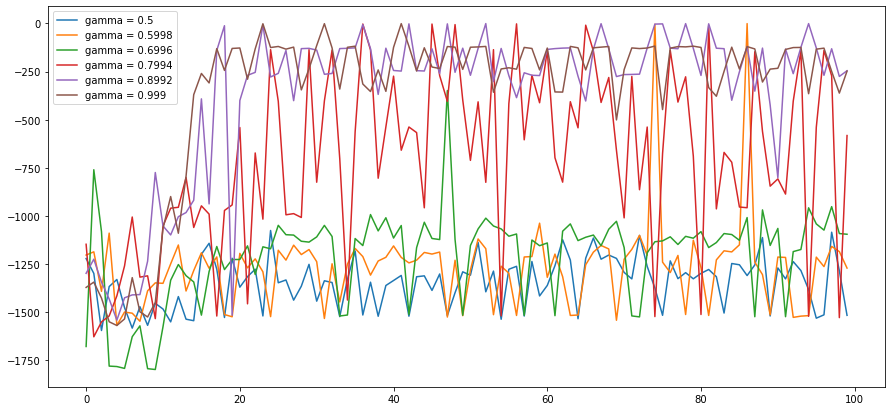

In [28]:
plot_data("gamma")

On peut remarquer que plus la valeur de $\gamma$ est élevé, plus l'algorithme converge vers une politique proche de l'optimale. Il semble y avoir un seuil $\gamma = 0.8$ en dessous duquel l'algorithme ne converge clairement plus vers la politique optimale. En observant les réalisations de ces entraînements pour de petits $\gamma$, on remarque que le pendule ne parvient pas à atteindre l'objectif.

### Learning rates

Faisons varier le learning rate de l'acteur 

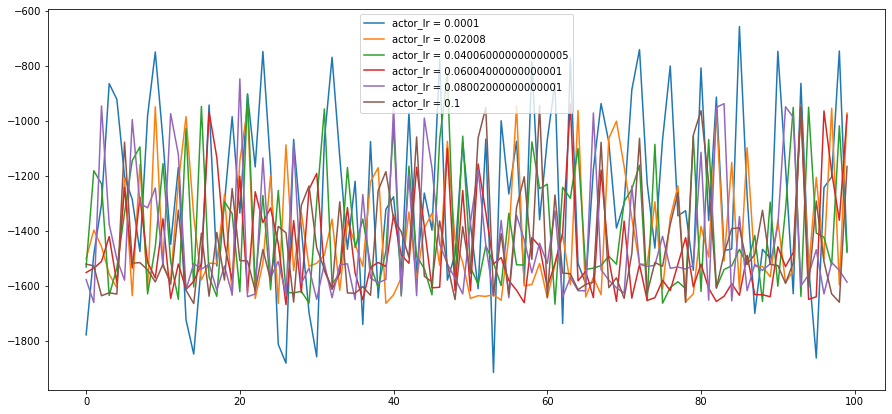

In [31]:
plot_data("actor_lr")

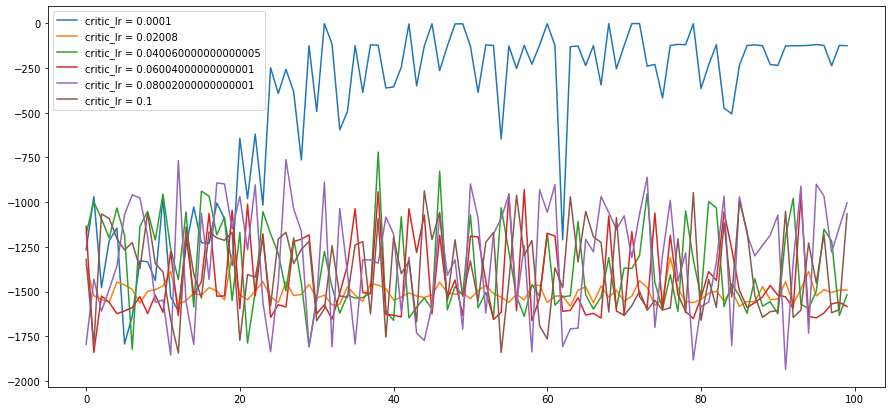

In [35]:
plot_data("critic_lr")

### Tau $\tau$

Faisons varier le paramètre $\tau$ qui sert à mettre à jour les réseaux de neurones targets de l'acteur et du critique.

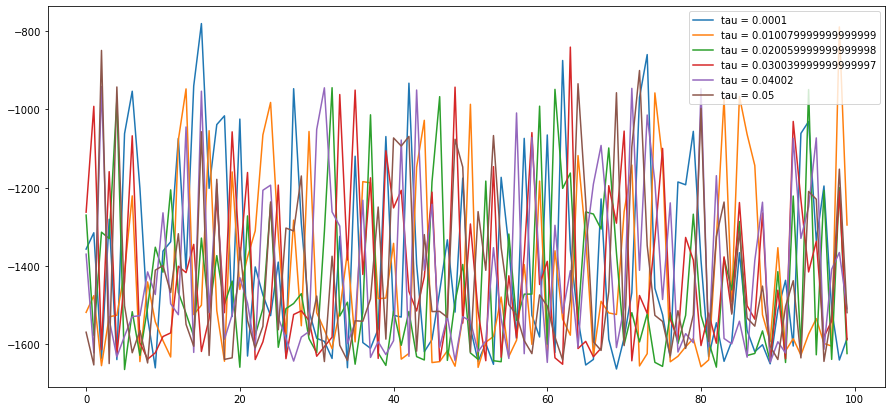

In [36]:
plot_data("tau")

### Taille de l'échantillon d'entraînement

Faisons varier le paramètre 'batch_size' qui détermine le nombre d'étapes à considérer à optimisation par gradient des réseaux de neurones acteur/critique.

Jouons une partie 

In [56]:
def save_data(filename, data):
    import pickle
    with open(f"Pendulum/results/{filename}", "wb") as fichier:
        pickle.dump(data, fichier)

In [55]:
def simulate_and_save(parameter_name):
    std_dev = 0.25
    critic_lr = 0.002
    actor_lr = 0.001
    gamma = 0.99
    tau = 0.005
    batch_size = 64
    parameters = [std_dev, critic_lr, actor_lr, gamma, tau, batch_size]
    ranges = {
        "gamma" : np.append(np.linspace(0.5, 0.999, 6), gamma),
        "critic_lr" : np.append(np.linspace(0.0001, 0.1, 6), critic_lr),
        "actor_lr" : np.append(np.linspace(0.0001, 0.1, 6), actor_lr),
        "tau" : np.append(np.linspace(0.0001, 0.05, 6), tau),
        "batch_size" : np.append(np.arange(16, 128, 16), batch_size),
        "std_dev": np.append(np.linspace(0.1, 0.5, 6), std_dev)
    }
    if parameter_name == "gamma" or parameter_name == "all":
        simulate_and_save_gamma(parameters, ranges["gamma"])
    if parameter_name == "critic_lr" or parameter_name == "all":
        simulate_and_save_critic_lr(parameters, ranges["critic_lr"])
    if parameter_name == "actor_lr" or parameter_name == "all":
        simulate_and_save_actor_lr(parameters, ranges["actor_lr"])
    if parameter_name == "tau" or parameter_name == "all":
        simulate_and_save_tau(parameters, ranges["tau"])
    if parameter_name == "batch_size" or parameter_name == "all":
        simulate_and_save_batch_size(parameters, ranges["batch_size"])
    if parameter_name == "std_dev_norm" or parameter_name == "all":
        simulate_and_save_std_dev_gaussien(parameters, ranges["std_dev_norm"])
    if parameter_name == "std_dev_ou" or parameter_name == "all":
        simulate_and_save_std_dev_ou(parameters, ranges["std_dev_ou"])

def simulate_and_save_gamma(parameters, parameter_range):
    std_dev, critic_lr, actor_lr, gamma,tau, batch_size = parameters
    current_simulation = 0
    data_to_save = []

    print("Simulation du paramètre gamma en cours")
    for gam in parameter_range:
        ddpg = DDPG(gam, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
        ddpg.train(debug = False)
        test = {
            "parameters": {
                "gamma" : gam,
                "tau" : tau,
                "actor_lr" : actor_lr,
                "critic_lr" : critic_lr,
                "bruit" : Bruit.Gaussien,
                "std_dev" : std_dev,
                "batch_size" : batch_size
            },
            "data": {
                "episode_rewards" : ddpg.episode_rewards
            }
        }
        data_to_save.append(test)
        print(f"Simulation {current_simulation} / {len(parameter_range)} terminée")
        current_simulation += 1
    save_data("DDPG_range_gamma", data_to_save)
    print("Simulation du paramètre gamma terminée")
    
def simulate_and_save_actor_lr(parameters, parameter_range):
    std_dev, critic_lr, actor_lr, gamma, tau, batch_size = parameters
    current_simulation = 0
    data_to_save = []

    print("Simulation du paramètre actor_lr en cours")
    for act_lr in parameter_range:
        ddpg = DDPG(gamma, ac_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
        ddpg.train(debug = False)
        test = {
            "parameters": {
                "gamma" : gamma,
                "tau" : tau,
                "actor_lr" : act_lr,
                "critic_lr" : critic_lr,
                "bruit" : Bruit.Gaussien,
                "std_dev" : std_dev,
                "batch_size" : batch_size
            },
            "data": {
                "episode_rewards" : ddpg.episode_rewards
            }
        }
        data_to_save.append(test)
        print(f"Simulation {current_simulation} / {len(parameter_range)} terminée")
        current_simulation += 1
    save_data("DDPG_range_actor_lr", data_to_save)
    print("Simulation du paramètre actor_lr terminée")

def simulate_and_save_tau(parameters, parameter_range):
    std_dev, critic_lr, actor_lr, gamma, tau, batch_size = parameters
    current_simulation = 0
    data_to_save = []

    print("Simulation du paramètre tau en cours")
    for t in parameter_range:
        ddpg = DDPG(gamma, actor_lr, critic_lr, t, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
        ddpg.train(debug = False)
        test = {
            "parameters": {
                "gamma" : gamma,
                "tau" : t,
                "actor_lr" : actor_lr,
                "critic_lr" : critic_lr,
                "bruit" : Bruit.Gaussien,
                "std_dev" : std_dev,
                "batch_size" : batch_size
            },
            "data": {
                "episode_rewards" : ddpg.episode_rewards
            }
        }
        data_to_save.append(test)
        print(f"Simulation {current_simulation} / {len(parameter_range)} terminée")
        current_simulation += 1
    save_data("DDPG_range_tau", data_to_save)
    print("Simulation du paramètre tau terminée")
          
def simulate_and_save_critic_lr(parameters, parameter_range):
    std_dev, critic_lr, actor_lr, gamma,tau, batch_size = parameters
    current_simulation = 0
    data_to_save = []

    print("Simulation du paramètre critic_lr en cours")
    for cr_lr in parameter_range:
        ddpg = DDPG(gamma, actor_lr, cr_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
        ddpg.train(debug = False)
        test = {
            "parameters": {
                "gamma" : gamma,
                "tau" : tau,
                "actor_lr" : actor_lr,
                "critic_lr" : cr_lr,
                "bruit" : Bruit.Gaussien,
                "std_dev" : std_dev,
                "batch_size" : batch_size
            },
            "data": {
                "episode_rewards" : ddpg.episode_rewards
            }
        }
        data_to_save.append(test)
        print(f"Simulation {current_simulation} / {len(parameter_range)} terminée")
        current_simulation += 1
    
    save_data("DDPG_range_critic_lr", data_to_save)
    print("Simulation du paramètre critic_lr terminée")

def simulate_and_save_batch_size(parameters, parameter_range):
    std_dev, critic_lr, actor_lr, gamma, tau, batch_size = parameters
    current_simulation = 0
    data_to_save = []

    print("Simulation du paramètre batch_size en cours")
    for b_size in parameter_range:
        ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=b_size, bruit = Bruit.Gaussien, std_dev = std_dev)
        ddpg.train(debug = False)
        test = {
            "parameters": {
                "gamma" : gamma,
                "tau" : tau,
                "actor_lr" : actor_lr,
                "critic_lr" : critic_lr,
                "bruit" : Bruit.Gaussien,
                "std_dev" : std_dev,
                "batch_size" : b_size
            },
            "data": {
                "episode_rewards" : ddpg.episode_rewards
            }
        }
        data_to_save.append(test)
        print(f"Simulation {current_simulation} / {len(parameter_range)} terminée")
        current_simulation += 1

    save_data("DDPG_range_batch_size", data_to_save)
    print("Simulation du paramètre batch_size terminée")
    
def simulate_and_save_std_dev_gaussien(parameters, parameter_range):
    std_dev, critic_lr, actor_lr, gamma, tau, batch_size = parameters
    current_simulation = 0
    data_to_save = []

    print("Simulation du paramètre std_dev en cours")
    for dev in parameter_range:
        ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=b_size, bruit = Bruit.Gaussien, std_dev = dev)
        ddpg.train(debug = False)
        test = {
            "parameters": {
                "gamma" : gamma,
                "tau" : tau,
                "actor_lr" : actor_lr,
                "critic_lr" : critic_lr,
                "bruit" : Bruit.Gaussien,
                "std_dev" : dev,
                "batch_size" : batch_size
            },
            "data": {
                "episode_rewards" : ddpg.episode_rewards
            }
        }
        data_to_save.append(test)
        print(f"Simulation {current_simulation} / {len(parameter_range)} terminée")
        current_simulation += 1

    save_data("DDPG_range_std_dev_gaussian", data_to_save)
    print("Simulation du paramètre std_dev gaussian terminée")

def simulate_and_save_std_dev_ou(parameters, parameter_range):
    std_dev, critic_lr, actor_lr, gamma, tau, batch_size = parameters
    current_simulation = 0
    data_to_save = []

    print("Simulation du paramètre std_dev OU en cours")
    for dev in parameter_range:
        ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=b_size, bruit = Bruit.OU, std_dev = dev)
        ddpg.train(debug = False)
        test = {
            "parameters": {
                "gamma" : gamma,
                "tau" : tau,
                "actor_lr" : actor_lr,
                "critic_lr" : critic_lr,
                "bruit" : Bruit.OU,
                "std_dev" : dev,
                "batch_size" : batch_size
            },
            "data": {
                "episode_rewards" : ddpg.episode_rewards
            }
        }
        data_to_save.append(test)
        print(f"Simulation {current_simulation} / {len(parameter_range)} terminée")
        current_simulation += 1

    save_data("DDPG_range_std_dev_ou", data_to_save)
    print("Simulation du paramètre std_dev OU terminée")

In [54]:
simulate_and_save("all")

Simulation du paramètre gamma en cours
Entrainement terminé


NameError: name 'data_to_save' is not defined

In [ ]:
std_dev = 0.25
critic_lr = 0.002
actor_lr = 0.001
gamma = 0.99
tau = 0.005
batch_size = 64
ranges = {
    "gamma" : np.linspace(0.5, 0.999, 6),
    "critic_lr" : np.linspace(0.0001, 0.1, 6),
    "actor_lr" : np.linspace(0.0001, 0.1, 6),
    "tau" : np.linspace(0.0001, 0.05, 6),
    "batch_size" : np.arange(16, 128, 16),
    "std_dev": np.linspace(0.1, 0.5, 6)
}
total_simulations = 46
current_simulation = 1
data_to_save = []

for gamma in ranges["gamma"] : 
    print(f"Simulation {current_simulation} / {total_simulations} en cours")
    ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
    ddpg.train(debug = False)
    test = {
        "parameters": {
            "gamma" : gamma,
            "tau" : tau,
            "actor_lr" : actor_lr,
            "critic_lr" : critic_lr,
            "bruit" : Bruit.Gaussien,
            "std_dev" : std_dev,
            "batch_size" : batch_size
        },
        "data": {
            "episode_rewards" : ddpg.episode_rewards
        }
    }
    data_to_save.append(test)
    print(f"Simulation {current_simulation} / {total_simulations} terminée")
    current_simulation += 1
save_data("DDPG_range_gamma", data_to_save)
data_to_save = []

for critic_lr in ranges["critic_lr"] : 
    print(f"Simulation {current_simulation} / {total_simulations} en cours")
    ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
    ddpg.train(debug = False)
    test = {
        "parameters": {
            "gamma" : gamma,
            "tau" : tau,
            "actor_lr" : actor_lr,
            "critic_lr" : critic_lr,
            "bruit" : Bruit.Gaussien,
            "std_dev" : std_dev,
            "batch_size" : batch_size
        },
        "data": {
            "episode_rewards" : ddpg.episode_rewards
        }
    }
    data_to_save.append(test)
    print(f"Simulation {current_simulation} / {total_simulations} terminée")
    current_simulation += 1

save_data("DDPG_range_critic_lr", data_to_save)
data_to_save = []

for actor_lr in ranges["actor_lr"] : 
    print(f"Simulation {current_simulation} / {total_simulations} en cours")
    ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
    ddpg.train(debug = False)
    test = {
        "parameters": {
            "gamma" : gamma,
            "tau" : tau,
            "actor_lr" : actor_lr,
            "critic_lr" : critic_lr,
            "bruit" : Bruit.Gaussien,
            "std_dev" : std_dev,
            "batch_size" : batch_size
        },
        "data": {
            "episode_rewards" : ddpg.episode_rewards
        }
    }
    data_to_save.append(test)
    print(f"Simulation {current_simulation} / {total_simulations} terminée")
    current_simulation += 1

save_data("DDPG_range_actor_lr", data_to_save)
data_to_save = []


for tau in ranges["tau"] : 
    print(f"Simulation {current_simulation} / {total_simulations} en cours")
    ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
    ddpg.train(debug = False)
    test = {
        "parameters": {
            "gamma" : gamma,
            "tau" : tau,
            "actor_lr" : actor_lr,
            "critic_lr" : critic_lr,
            "bruit" : Bruit.Gaussien,
            "std_dev" : std_dev,
            "batch_size" : batch_size
        },
        "data": {
            "episode_rewards" : ddpg.episode_rewards
        }
    }
    data_to_save.append(test)
    print(f"Simulation {current_simulation} / {total_simulations} terminée")
    current_simulation += 1

save_data("DDPG_range_tau", data_to_save)
data_to_save = []


for batch_size in ranges["batch_size"] : 
    ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
    ddpg.train(debug = False)
    test = {
        "parameters": {
            "gamma" : gamma,
            "tau" : tau,
            "actor_lr" : actor_lr,
            "critic_lr" : critic_lr,
            "bruit" : Bruit.Gaussien,
            "std_dev" : std_dev,
            "batch_size" : batch_size
        },
        "data": {
            "episode_rewards" : ddpg.episode_rewards
        }
    }
    data_to_save.append(test)
    print(f"Simulation {current_simulation} / {total_simulations} terminée")
    current_simulation += 1

save_data("DDPG_range_batch_size", data_to_save)
data_to_save = []


for std_dev in ranges["std_dev"] : 
    ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.OU, std_dev = std_dev)
    ddpg.train(debug = False)
    test = {
        "parameters": {
            "gamma" : gamma,
            "tau" : tau,
            "actor_lr" : actor_lr,
            "critic_lr" : critic_lr,
            "bruit" : Bruit.OU,
            "std_dev" : std_dev,
            "batch_size" : batch_size
        },
        "data": {
            "episode_rewards" : ddpg.episode_rewards
        }
    }
    data_to_save.append(test)
    print(f"Simulation {current_simulation} / {total_simulations} terminée")
    current_simulation += 1

save_data("DDPG_range_std_dev_ou_noise", data_to_save)
data_to_save = []


    
for std_dev in ranges["std_dev"] : 
    print(f"Simulation {current_simulation} / {total_simulations} en cours")
    ddpg = DDPG(gamma, actor_lr, critic_lr, tau, total_episodes, batch_size=batch_size, bruit = Bruit.Gaussien, std_dev = std_dev)
    ddpg.train(debug = False)
    test = {
        "parameters": {
            "gamma" : gamma,
            "tau" : tau,
            "actor_lr" : actor_lr,
            "critic_lr" : critic_lr,
            "bruit" : Bruit.Gaussien,
            "std_dev" : std_dev,
            "batch_size" : batch_size
        },
        "data": {
            "episode_rewards" : ddpg.episode_rewards
        }
    }
    data_to_save.append(test)
    print(f"Simulation {current_simulation} / {total_simulations} terminée")
    current_simulation += 1

save_data("DDPG_range_std_dev_gaussian_noise", data_to_save)
data_to_save = []



In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")